<a href="https://colab.research.google.com/github/DunkleCat/ia-telco/blob/master/telco_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerie

In [1]:
# Generici
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, normalize

# Classificatori
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, PassiveAggressiveRegressor, RidgeClassifierCV

# Rete neurale
import tensorflow as tf

# Rende i numeri a virgola mobile più leggibili
np.set_printoptions(precision=3, suppress=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Dataframe

## Download del dataframe

In [2]:
csv_file = "/content/drive/My Drive/datasets/Telco-Customer-Churn.csv"
dataframe = pd.read_csv(csv_file)
target_label = "Churn"

## Ottimizzazione del dataframe 



Vediamo cosa contiene il dataframe:

In [3]:
dataframe.head()

,Churn,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,No,4223-BKEOR,Female,0,No,Yes,21,Yes,No,DSL,Yes,No,Yes,No,No,Yes,One year,No,Mailed check,64.85,1336.8
1,No,6035-RIIOM,Female,0,No,No,54,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),97.20,5129.45
2,Yes,3797-VTIDR,Male,0,Yes,No,1,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,23.45,23.45
3,Yes,2568-BRGYX,Male,0,No,No,4,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.20,237.95
4,No,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,


In [4]:
# Dataframe informations
print("Dataframe miscellaneous:\n")
print("Rows     : {}".format(dataframe.shape[0]) )
print("Columns  : {}".format(dataframe.shape[1]))
print("\nFeatures :\n{}".format(dataframe.columns.tolist()))
print("\nUnique values :\n{}".format(dataframe.nunique()))

print("\nDataframe info:")
dataframe.info()

Dataframe miscellaneous:

Rows     : 5634
Columns  : 21

Features :
['Churn', 'customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

Unique values :
Churn                  2
customerID          5634
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1495
TotalCharges        5300
dtype: int64

Dataframe info:
<class 'pandas.core.frame.DataFrame'

Una colonna di ID non ci sarà mai utile. Oltretutto tocca eliminare tutte le righe che hanno valori nulli (sperando di non cancellarne troppe).

In più l'ultima colonna è considerata piena di string, mentre in realtà sono float.

In [5]:
# Useless column
dataframe.pop('customerID')

# Deleting NaN values
dataframe.replace(" ", np.nan, inplace=True)

print("\nNaN values before:\n{}".format(dataframe.isna().sum()))
dataframe.dropna(inplace=True)
print("\nNaN values after:\n{}".format(dataframe.isna().sum()))


NaN values before:
Churn                0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        10
dtype: int64

NaN values after:
Churn               0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


Ora passiamo all'analisi di parte dei dati del dataframe per trovare colonne che potrebbero non contribuire alla previsione del risultato.

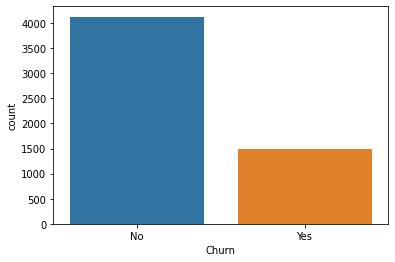

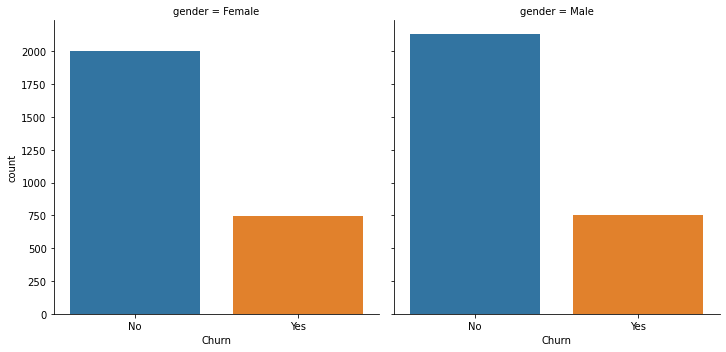

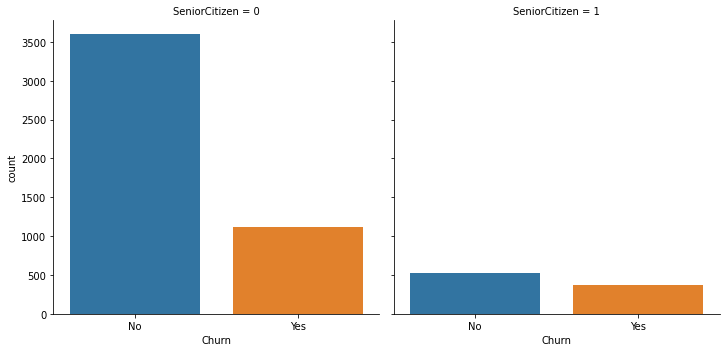

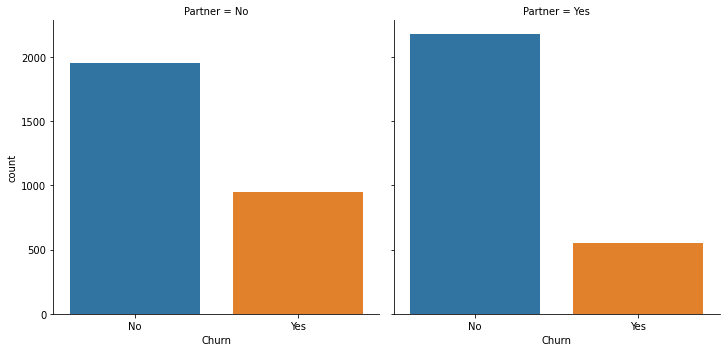

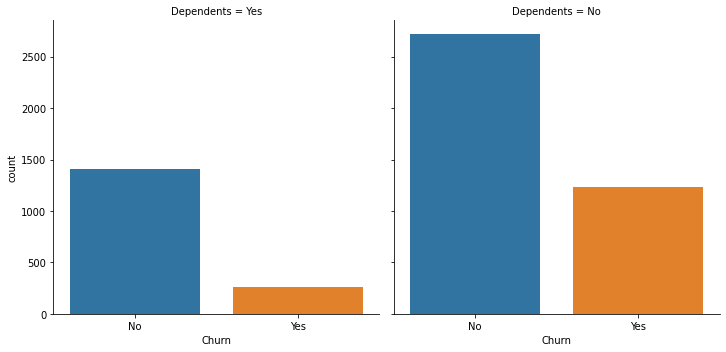

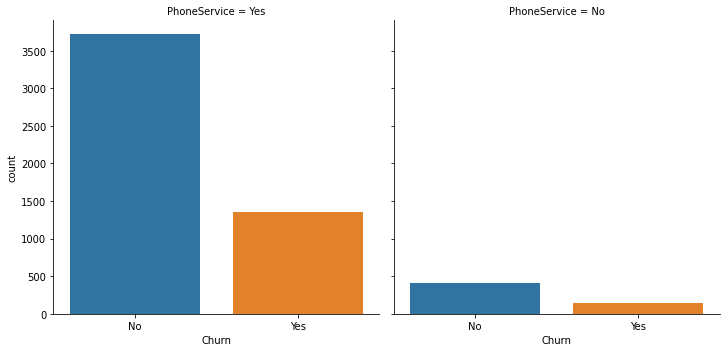

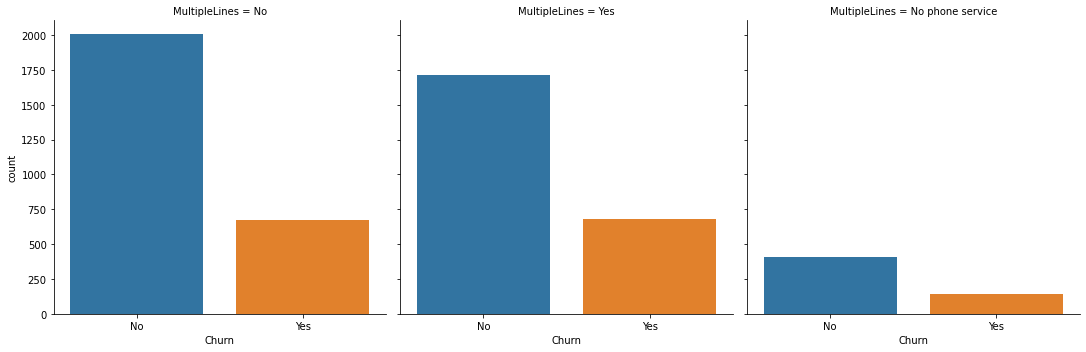

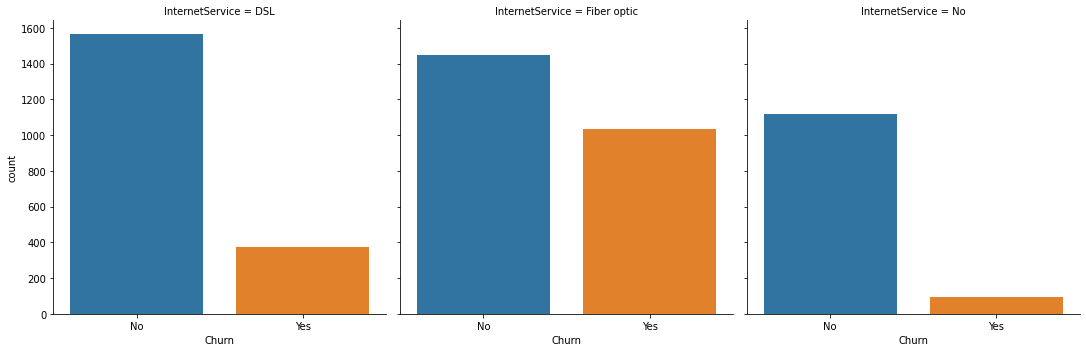

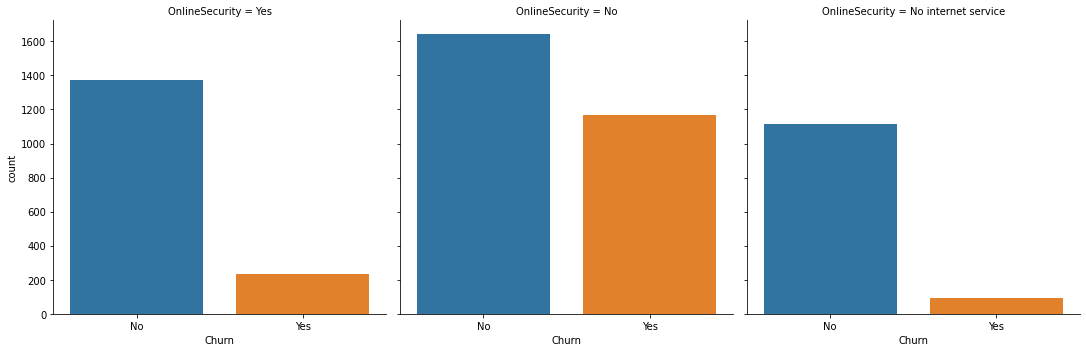

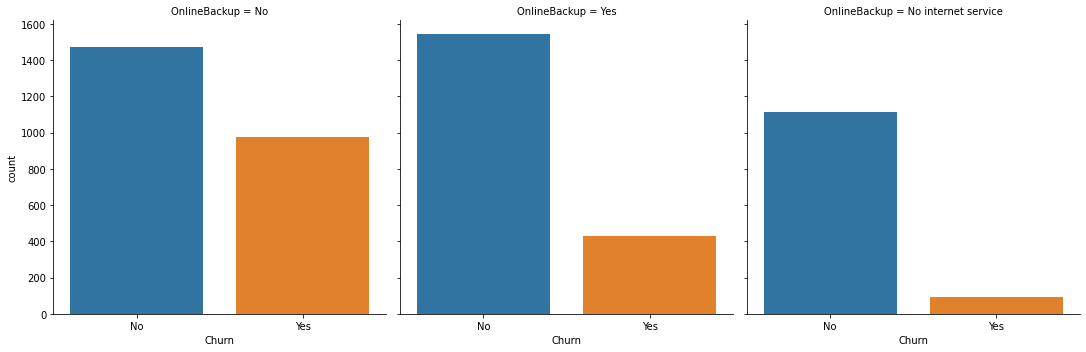

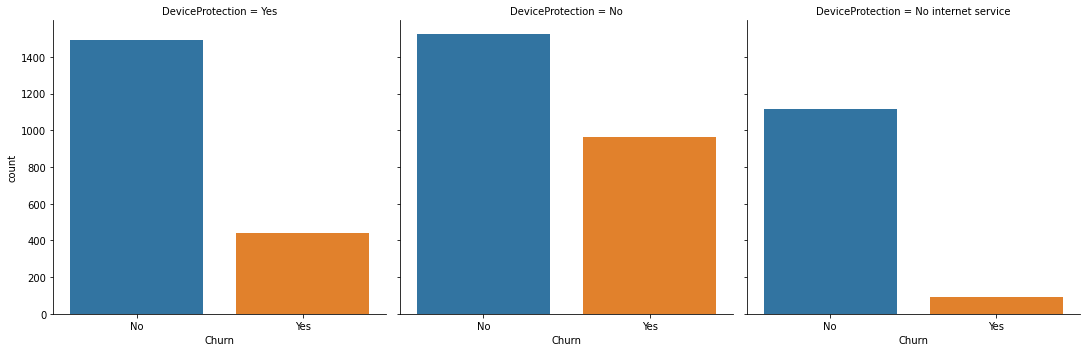

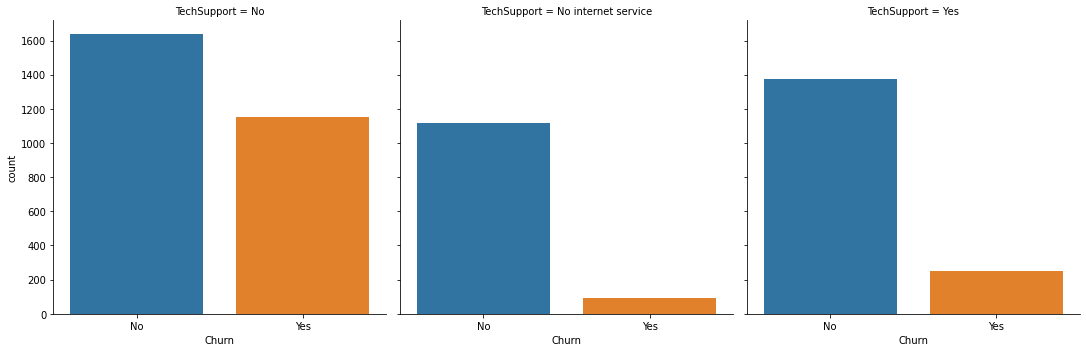

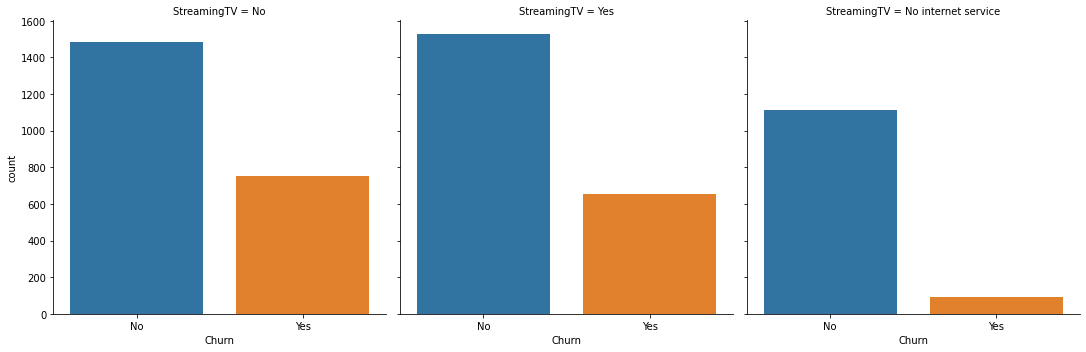

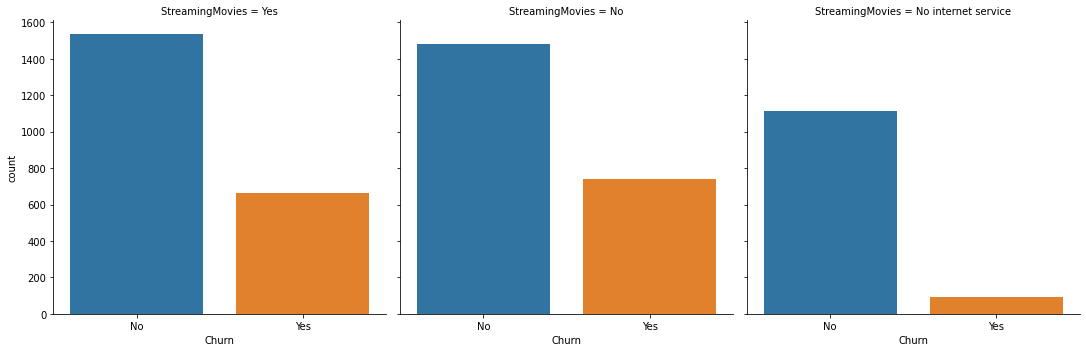

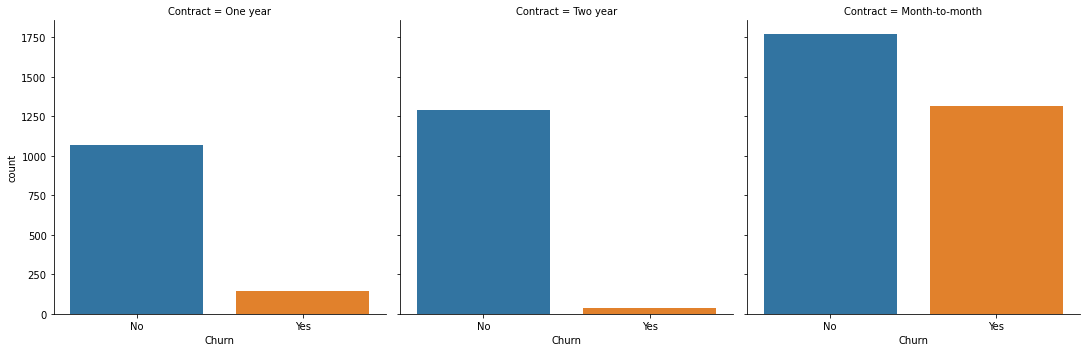

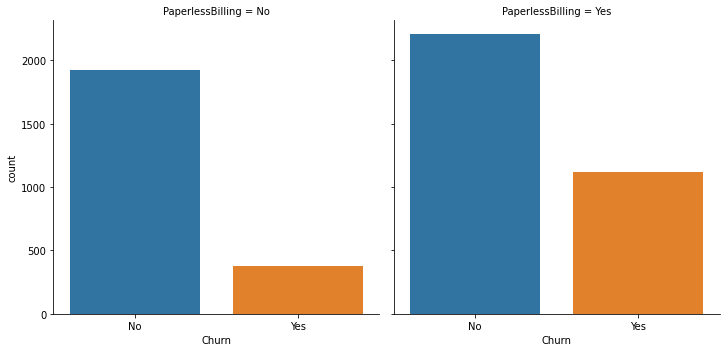

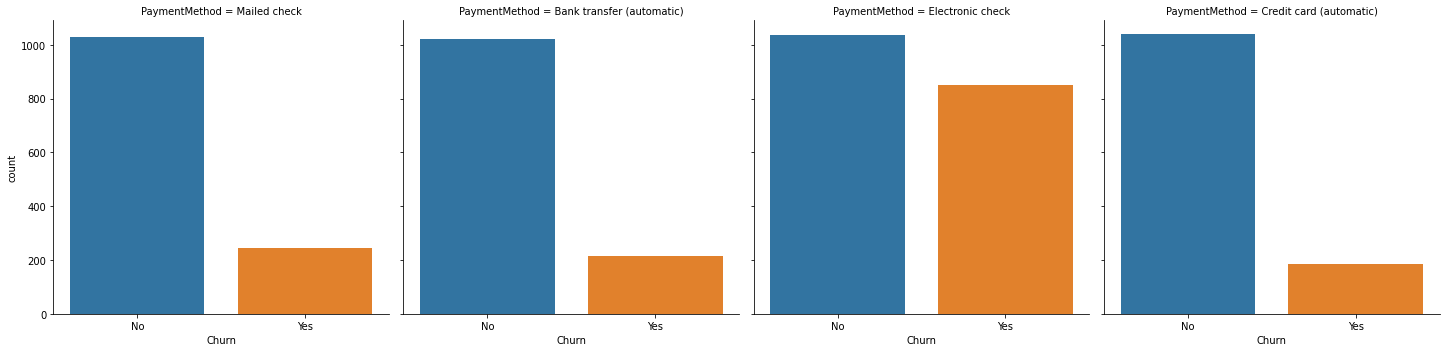

In [6]:
nonclass_features = ['Churn', 'tenure', 'MonthlyCharges', 'TotalCharges']

plot = sb.countplot(dataframe['Churn'])
plt.show()

for elem in dataframe:
  if elem not in nonclass_features:
    plot = sb.catplot(x = 'Churn', col = elem, data = dataframe, kind = 'count')
  plt.show()

Sembra che il genere ed il partner non influenzino la decisione, per cui verranno rimossi 

In [7]:
pop_features = []
# pop_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines' ]
# pop_features = ['gender', 'tenure','PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for elem in pop_features:
  dataframe.pop(elem) 

La rete neurale lavora sfruttando i numeri e non le stringhe. Per questo motivo conviene trasformare ogni colonna che contiene stringhe in numeri interi che rappresentino la classe dell'elemento corrispondente. 

In [8]:
for elem in dataframe:
  if type(dataframe[elem][1]) is str:
    dataframe[elem] = pd.Categorical(dataframe[elem])
    dataframe[elem] = getattr(dataframe, elem).cat.codes


dataframe.dtypes

Churn                  int8
gender                 int8
SeniorCitizen         int64
Partner                int8
Dependents             int8
tenure                int64
PhoneService           int8
MultipleLines          int8
InternetService        int8
OnlineSecurity         int8
OnlineBackup           int8
DeviceProtection       int8
TechSupport            int8
StreamingTV            int8
StreamingMovies        int8
Contract               int8
PaperlessBilling       int8
PaymentMethod          int8
MonthlyCharges      float64
TotalCharges          int16
dtype: object

Ora trasformiamo tutto in float64, il tipo che verrà utilizzato successivamente

In [9]:
for elem in dataframe:
  dataframe[elem] = dataframe[elem].astype('float')

# dataframe = normalize(dataframe)

Ed ecco cosa contiere il nostro dataframe ora:

In [10]:
dataframe.head()

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0.0,0.0,0.0,0.0,1.0,21.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,3.0,64.85,491.0
1,0.0,0.0,0.0,0.0,0.0,54.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,1.0,0.0,97.20,3510.0
2,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,23.45,1565.0
3,1.0,1.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,70.20,1626.0
5,0.0,1.0,0.0,0.0,0.0,7.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,69.55,3548.0


In [11]:
dataframe.dtypes

Churn               float64
gender              float64
SeniorCitizen       float64
Partner             float64
Dependents          float64
tenure              float64
PhoneService        float64
MultipleLines       float64
InternetService     float64
OnlineSecurity      float64
OnlineBackup        float64
DeviceProtection    float64
TechSupport         float64
StreamingTV         float64
StreamingMovies     float64
Contract            float64
PaperlessBilling    float64
PaymentMethod       float64
MonthlyCharges      float64
TotalCharges        float64
dtype: object

In [12]:
dataframe.describe()

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,5624.000000,5624.000000,5624.000000,5624.000000,5624.000000,5624.000000,5624.000000,5624.000000,5624.000000,5624.000000,5624.000000,5624.000000,5624.000000,5624.000000,5624.000000,5624.00000,5624.000000,5624.000000,5624.000000,5624.000000
mean,0.266003,0.512269,0.161095,0.483997,0.297475,32.430654,0.902205,0.949147,0.870733,0.785917,0.915007,0.900427,0.793030,0.989331,0.995733,0.68830,0.590683,1.569168,64.911620,2650.028094
std,0.441905,0.499894,0.367652,0.499788,0.457188,24.408029,0.297064,0.948567,0.736370,0.859946,0.882112,0.880585,0.861685,0.886133,0.886187,0.82924,0.491752,1.066948,30.081601,1530.269334
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,18.250000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,35.800000,1295.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.00000,1.000000,2.000000,70.550000,2645.500000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.00000,1.000000,2.000000,89.950000,3980.250000
max,1.000000,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,1.000000,3.000000,118.600000,5298.000000


# Classificatori

## Preparazione del classificatore

In [13]:
train, test = train_test_split(dataframe, test_size=0.1)
print(len(train), 'train examples')
print(len(test), 'test examples')

models = []
models.append(RandomForestClassifier(random_state=50))
models.append(DecisionTreeClassifier(random_state=1))
models.append(LogisticRegression(random_state=1))

5061 train examples
563 test examples


## Addestramento

In [14]:
def fit(model):
  global train
  global train_target

  model.fit(normalize(train), train_target)
  print(type(model).__name__)

train_target = train.pop(target_label)
list(map(fit, models))

RandomForestClassifier
DecisionTreeClassifier
PassiveAggressiveClassifier
RidgeClassifierCV
LogisticRegression


[None, None, None, None, None]

## Test

[RandomForestClassifier]: Test Accuracy 0.7264653641207816


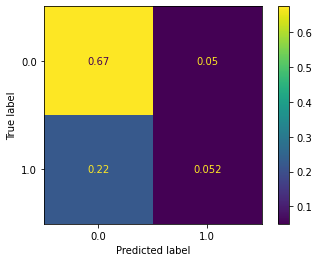

[DecisionTreeClassifier]: Test Accuracy 0.6429840142095915


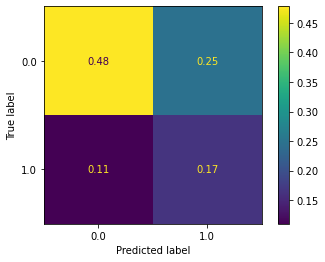

[PassiveAggressiveClassifier]: Test Accuracy 0.2877442273534636


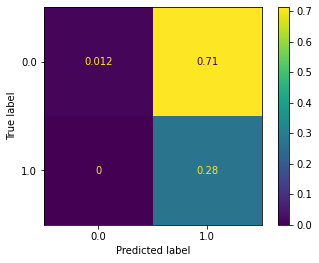

[RidgeClassifierCV]: Test Accuracy 0.3037300177619893


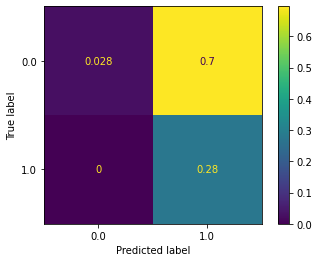

[LogisticRegression]: Test Accuracy 0.2877442273534636


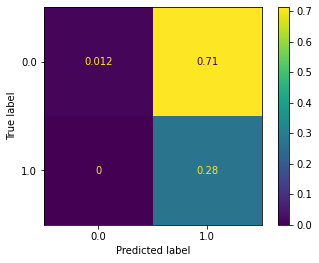

[None, None, None, None, None]

In [15]:
def predict(model):
  global test
  global test_target

  preds = model.predict(test)
  test_accuracy = metrics.accuracy_score(test_target, preds)
  print('[{}]: Test Accuracy {}'.format(type(model).__name__, test_accuracy))
  metrics.plot_confusion_matrix(model, test, test_target, normalize='all')
  plt.show()

test_target = test.pop(target_label)
train = normalize(train)

list(map(predict, models))